In [1]:
import pandas as pd
import numpy as np
import opendatasets as od
import os
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime

#Local Libraries
import wrangle_o
import utilities
import modeling

np.random.seed(123)

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

In [2]:
wrangle_o.pull_data()

Olympic data pulled


In [3]:
# To fill na, adjust "born" column to approriate date formats
wrangle_o.athlete_bio()

In [4]:
bio = pd.read_csv('clean_olympic_athlete_bio.csv',keep_default_na=False)
er = pd.read_csv('Olympic_Athlete_Event_Results.csv')
res = pd.read_csv('Olympic_Results.csv')
country = pd.read_csv('Olympics_country.csv')
games = pd.read_csv('Olympics_Games.csv')
mt = pd.read_csv('Olympic_Games_Medal_Tally.csv')

In [5]:
olympics = wrangle_o.merge_data(bio, er, res, country, games)

Use df: 'olympics'


In [6]:
olympics = wrangle_o.wrangle_olympics(olympics)

In [7]:
# Long code of replacing weight measurements and birth data- Takes a bit of time
olympics = wrangle_o.replace_olympics(olympics)

In [8]:
wrangle_o.height_weight_age_data(olympics)
olympics = olympics.drop(['born','year_born'], axis=1)
olympics

,athlete_id,name,sex,height,weight,country,country_noc_x,edition,sport,event,result_id,medal,isTeamSport,city,country_noc_y,event_year,medalist,home,age,bmi
0,14503,scar Giraldo,Male,175.37,70.62,Colombia,COL,Summer Olympics,Cycling Road,"Road Race, Individual, Men",154878,participant,0,Atlanta,USA,1996-01-01,0,0,22.00,22.96
1,58758,Hossein Mollaghasemi,Male,173.00,63.00,Islamic Republic of Iran,IRI,Summer Olympics,Wrestling,"Featherweight, Greco-Roman, Men",124658,participant,0,Roma,ITA,1960-01-01,0,0,26.00,21.05
2,58758,Hossein Mollaghasemi,Male,173.00,63.00,Islamic Republic of Iran,IRI,Summer Olympics,Wrestling,"Lightweight, Greco-Roman, Men",125396,participant,0,Tokyo,JPN,1964-01-01,0,0,30.00,21.05
3,90217,Enrico Lazzarotto,Male,178.00,72.00,Italy,ITA,Summer Olympics,Canoe Slalom,"Kayak Singles, Slalom, Men",256271,participant,0,Sydney,AUS,2000-01-01,0,0,26.00,22.72
4,74565,John Hou,Male,178.00,60.00,Papua New Guinea,PNG,Summer Olympics,Athletics,"100 metres, Men",63261,participant,0,Seoul,KOR,1988-01-01,0,0,20.00,18.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314720,30727,Armando Valles,Male,170.00,68.00,Mexico,MEX,Summer Olympics,Artistic Gymnastics,"Horse Vault, Men",70306,participant,0,Ciudad de México,MEX,1968-01-01,0,1,26.00,23.53
314721,30727,Armando Valles,Male,170.00,68.00,Mexico,MEX,Summer Olympics,Artistic Gymnastics,"Parallel Bars, Men",70309,participant,0,Ciudad de México,MEX,1968-01-01,0,1,26.00,23.53
314722,30727,Armando Valles,Male,170.00,68.00,Mexico,MEX,Summer Olympics,Artistic Gymnastics,"Horizontal Bar, Men",70312,participant,0,Ciudad de México,MEX,1968-01-01,0,1,26.00,23.53
314723,30727,Armando Valles,Male,170.00,68.00,Mexico,MEX,Summer Olympics,Artistic Gymnastics,"Rings, Men",70315,participant,0,Ciudad de México,MEX,1968-01-01,0,1,26.00,23.53


In [9]:
# Split Data
train, validate, test = utilities.split_data(olympics)
train.shape, validate.shape, test.shape

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


((176064, 20), (75457, 20), (62881, 20))

In [10]:
selected_features = ['home','isTeamSport','age','bmi']
target = 'medalist'

In [11]:
n = train.shape[0]
baseline_medal=train.medalist.sum()/n
baseline_medal

0.14215285350781534

In [12]:
X_train = train[selected_features]
y_train = train[[target]]

X_validate = validate[selected_features]
y_validate = validate[[target]]

X_test = test[selected_features]
y_test = test[[target]]

In [13]:
# Check Split
X_train[:3]

,home,isTeamSport,age,bmi
98265,0,1,32.00,27.34
177475,0,0,30.00,22.96
89882,0,1,22.00,23.72


In [14]:
y_train[:3]

,medalist
98265,0
177475,0
89882,0


## Decision Tree

In [15]:
depths =[]
min_samples = []
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []
min_samples_range = range(1,10)
d_range = range(1,10)
for d in d_range:
    for min_sample in min_samples_range:
        clf, train_report = modeling.decision_tree_train(X_train, y_train,selected_features, target, d=d, m = min_sample , print_results=False)
        validate_report = modeling.classifier_validate(X_validate,y_validate, clf, print_results=False)

        depths.append(d)
        min_samples.append(min_sample)
        train_accuracies.append(train_report['accuracy'])
        train_precisions.append(train_report['precision'])
        train_recalls.append(train_report['recall'])

        v_accuracies.append(validate_report['accuracy'])
        v_precisions.append(validate_report['precision'])
        v_recalls.append(validate_report['recall'])

train_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

combined_df = train_results_df.merge(validate_results_df,on=['max_depth','min_samples_leaf'], suffixes=['_train','_validate'])
combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train

combined_df = combined_df.sort_values(by =['accuracy_validate','accuracy_diff'], ascending=False)
print(f"Highest accuracy score on train:\n {combined_df.accuracy_train.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_train.idxmax()]} and min_sample_leaf of {combined_df.min_samples_leaf[combined_df.accuracy_train.idxmax()]}")
print(f"Highest accuracy score on validate:\n{combined_df.accuracy_validate.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_validate.idxmax()]} and min_sample_leaf of {combined_df.min_samples_leaf[combined_df.accuracy_validate.idxmax()]}")
print(f"This was a drop-off from train of:\n{combined_df.accuracy_diff[combined_df.accuracy_validate == combined_df.accuracy_validate.max()].array[0]}")
print(f"Lowest drop-off in accuracy from train to validate:\n {combined_df.accuracy_diff.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_diff == combined_df.accuracy_diff.max()].array[0]} and min sample leaf of  {combined_df.min_samples_leaf[combined_df.accuracy_diff == combined_df.accuracy_diff.max()].array[0]}")

decision_tree_final_results = combined_df
decision_tree_final_results["model"] = 'decision_tree'

Highest accuracy score on train:
 0.8590171755725191 with max depth setting of 9 and min_sample_leaf of 1
Highest accuracy score on validate:
0.8605695959288071 with max depth setting of 6 and min_sample_leaf of 6
This was a drop-off from train of:
0.0025009390767533057
Lowest drop-off in accuracy from train to validate:
 0.002695944274742179 with max depth setting of 1 and min sample leaf of  1


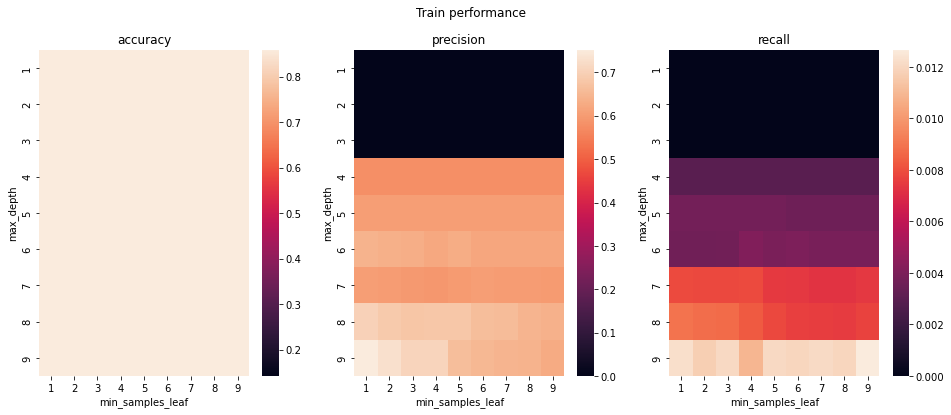

In [16]:
_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
for i, metric in enumerate(to_plot):
    heatmap_df = train_results_df.pivot("max_depth","min_samples_leaf",metric)
    # Set floor of accuracy at the baseline 
    if i == 0:
        sns.heatmap(heatmap_df, ax=ax[i], vmin = baseline_medal)
        ax[i].set_title(metric)
    else:
        sns.heatmap(heatmap_df, ax=ax[i])
        ax[i].set_title(metric)
    plt.suptitle('Train performance')

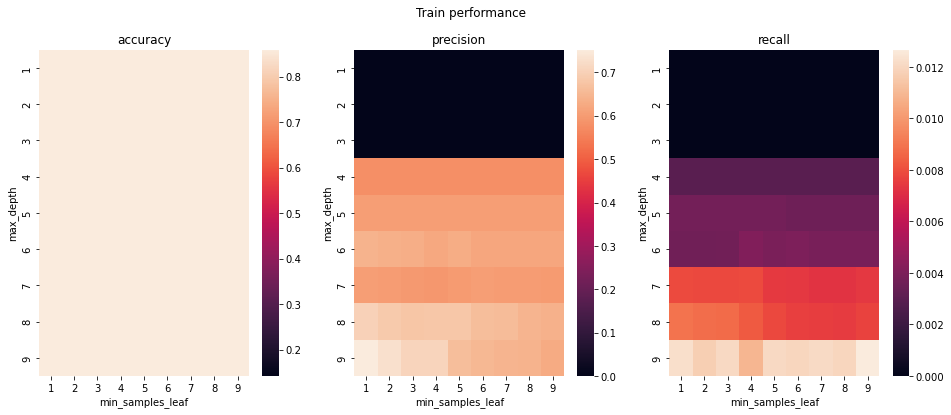

In [17]:
_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
for i, metric in enumerate(to_plot):
    heatmap_df = train_results_df.pivot("max_depth","min_samples_leaf",metric)
    # Set floor of accuracy at the baseline 
    if i == 0:
        sns.heatmap(heatmap_df, ax=ax[i], vmin = baseline_medal)
        ax[i].set_title(metric)
    else:
        sns.heatmap(heatmap_df, ax=ax[i])
        ax[i].set_title(metric)
    plt.suptitle('Train performance')

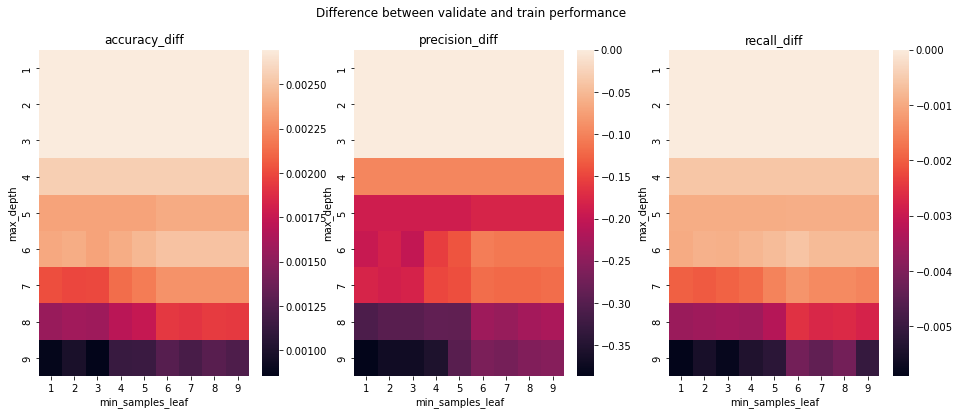

In [18]:
_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy_diff","precision_diff","recall_diff"]
for i, metric in enumerate(to_plot):
    heatmap_df = combined_df.pivot("max_depth","min_samples_leaf",metric)
    sns.heatmap(heatmap_df, ax=ax[i])
    plt.suptitle('Difference between validate and train performance')
    ax[i].set_title(metric)

### Random Forest

In [ ]:
depths =[]
min_samples = []
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []
min_samples_range = range(1,10)
d_range = range(1,10)
for d in d_range:
    for min_sample in min_samples_range:
        clf, train_report = modeling.random_forest_train(X_train, y_train,selected_features, target, d=d, m = min_sample , print_results=False)
        validate_report = modeling.classifier_validate(X_validate,y_validate, clf, print_results=False)

        depths.append(d)
        min_samples.append(min_sample)
        train_accuracies.append(train_report['accuracy'])
        train_precisions.append(train_report['precision'])
        train_recalls.append(train_report['recall'])

        v_accuracies.append(validate_report['accuracy'])
        v_precisions.append(validate_report['precision'])
        v_recalls.append(validate_report['recall'])

In [20]:
train_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

combined_df = train_results_df.merge(validate_results_df,on=['max_depth','min_samples_leaf'], suffixes=['_train','_validate'])
combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train

# Combine train and validate results as well as calculate difference in performance between train and validate
combined_df2 = modeling.consolidate_results(train_results_df, 
                                        validate_results_df, 
                                        join_on = ['max_depth','min_samples_leaf'])
combined_df2["algorithm"] = model_name
# Concatenate results into one dataframe to hold results for all models
all_results = pd.concat([all_results,combined_df2])

combined_df = combined_df.sort_values(by =['accuracy_validate','accuracy_diff'], ascending=False)
print(f"Highest accuracy score on train:\n {combined_df.accuracy_train.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_train.idxmax()]} and min_sample_leaf of {combined_df.min_samples_leaf[combined_df.accuracy_train.idxmax()]}")
print(f"Highest accuracy score on validate:\n{combined_df.accuracy_validate.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_validate.idxmax()]} and min_sample_leaf of {combined_df.min_samples_leaf[combined_df.accuracy_validate.idxmax()]}")
print(f"This was a drop-off from train of:\n{combined_df.accuracy_diff[combined_df.accuracy_validate == combined_df.accuracy_validate.max()].array[0]}")
print(f"Lowest drop-off in accuracy from train to validate:\n {combined_df.accuracy_diff.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_diff == combined_df.accuracy_diff.max()].array[0]} and min sample leaf of  {combined_df.min_samples_leaf[combined_df.accuracy_diff == combined_df.accuracy_diff.max()].array[0]}")

random_forest_final_results = combined_df
random_forest_final_results["model"] = 'random_forest'

AttributeError: module 'modeling' has no attribute 'consolidate_results'

In [ ]:
_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
    
for i, metric in enumerate(to_plot):
    heatmap_df = train_results_df.pivot("max_depth","min_samples_leaf",metric)
    # Set floor of accuracy at the baseline 
    if i == 0:
        sns.heatmap(heatmap_df, ax=ax[i], vmin = baseline_medal)
        ax[i].set_title(metric)
    else:
        sns.heatmap(heatmap_df, ax=ax[i])
        ax[i].set_title(metric)
    plt.suptitle('Train performance')

In [ ]:
_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
for i, metric in enumerate(to_plot):
    heatmap_df = validate_results_df.pivot("max_depth","min_samples_leaf",metric)
    # Set floor of accuracy at the baseline 
    if i == 0:
        sns.heatmap(heatmap_df, ax=ax[i], vmin = baseline_medal)
        ax[i].set_title(metric)
    else:
        sns.heatmap(heatmap_df, ax=ax[i])
        ax[i].set_title(metric)
    plt.suptitle('Validate performance')

In [ ]:
_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy_diff","precision_diff","recall_diff"]
for i, metric in enumerate(to_plot):
    heatmap_df = combined_df.pivot("max_depth","min_samples_leaf",metric)
    sns.heatmap(heatmap_df, ax=ax[i])
    plt.suptitle('Difference between validate and train performance')
    ax[i].set_title(metric)

### KNN

In [ ]:
ks =[]
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []

k_range = range(1,100)
for k in k_range:

    clf, train_report = modeling.knn_train(X_train, y_train, selected_features, target, k=k, print_results=False)
    validate_report = modeling.knn_validate(X_validate,y_validate, clf, print_results=False)

    ks.append(k)
    min_samples.append(min_sample)
    train_accuracies.append(train_report['accuracy'])
    train_precisions.append(train_report['precision'])
    train_recalls.append(train_report['recall'])

    v_accuracies.append(validate_report['accuracy'])
    v_precisions.append(validate_report['precision'])
    v_recalls.append(validate_report['recall'])

In [ ]:
train_results_df= pd.DataFrame(data = {"k":ks,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"k":ks,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

combined_df = train_results_df.merge(validate_results_df,on=['k'], suffixes=['_train','_validate'])
combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train

# Combine train and validate results as well as calculate difference in performance between train and validate
combined_df2 = modeling.consolidate_results(train_results_df, validate_results_df, join_on = ['k'])
combined_df2["algorithm"] = "k_nearest_neighbors"
# Concatenate results into one dataframe to hold results for all models
all_results = pd.concat([all_results,combined_df2])

combined_df = combined_df.sort_values(by =['accuracy_validate','accuracy_diff'], ascending=False)
print(f"Highest accuracy score on train:\n {combined_df.accuracy_train.max()} with k setting of {combined_df.k[combined_df.accuracy_train.idxmax()]}")
print(f"Highest accuracy score on validate:\n {combined_df.accuracy_validate.max()} with k setting of {combined_df.k[combined_df.accuracy_validate.idxmax()]}")
print(f"Lowest drop-off in accuracy from train to validate:\n {combined_df.accuracy_diff.min()} with k setting of {combined_df.k[combined_df.accuracy_diff == combined_df.accuracy_diff.min()].array[0]}")

knn_final_results = combined_df
knn_final_results["model"] = 'k_nearest_neighbors'

In [ ]:
# Melt metrics into same column to enable clean plotting with seaborn
data = pd.melt(combined_df.drop(columns = ['accuracy_diff','precision_diff','recall_diff']), id_vars =['k'], var_name='metric')

_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
for i, metric in enumerate(to_plot):
    sns.lineplot(x = data[data.metric.str.contains(metric)].k, 
                 y = data[data.metric.str.contains(metric)].value, 
                 hue = data[data.metric.str.contains(metric)].metric,  
                 ax=ax[i])
    
    plt.suptitle(f'KNN Train and validate performance \nPrecision and recall based on class 1')
    plt.tight_layout()
    #plt.xticks([analysis_range])
    ax[i].legend(title = 'data set')
    ax[i].set_title(metric)
    if metric == "accuracy":
        ax[i].set_title('Accuracy (Baseline accuracy shown in green)')
        ax[i].axhline(baseline_medal, color = 'green')

### Logistical Regression

In [ ]:
cs =[]
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []

c_range = np.linspace(0.01, 10000, num = 50)#[0.01, 0.1, 1.0, 10, 100, 1000, 10000]
for c in c_range:

    clf, train_report = modeling.logistic_regression_train(X_train, y_train, selected_features, target, c=c, print_results=False)
    validate_report = modeling.logisitic_regression_validate(X_validate,y_validate, clf, print_results=False)

    cs.append(clf.C)
    min_samples.append(min_sample)
    train_accuracies.append(train_report['accuracy'])
    train_precisions.append(train_report['precision'])
    train_recalls.append(train_report['recall'])

    v_accuracies.append(validate_report['accuracy'])
    v_precisions.append(validate_report['precision'])
    v_recalls.append(validate_report['recall'])

In [ ]:
train_results_df= pd.DataFrame(data = {"c":cs,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"c":cs,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

combined_df = train_results_df.merge(validate_results_df,on=['c'], suffixes=['_train','_validate'])
combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train

combined_df2 = modeling.consolidate_results(train_results_df, validate_results_df, join_on = ['c'])
combined_df2["algorithm"] = "logistic_regression"
all_results = pd.concat([all_results,combined_df2])

combined_df2 = modeling.consolidate_results(train_results_df, validate_results_df, join_on = ['c'])
combined_df2["algorithm"] = "logistic_regression"
all_results = pd.concat([all_results,combined_df2])

combined_df = combined_df.sort_values(by =['accuracy_validate','accuracy_diff'], ascending=False)
print(f"Highest accuracy score on train:\n {combined_df.accuracy_train.max()} with c setting of {combined_df.c[combined_df.accuracy_train.idxmax()]}")
print(f"Highest accuracy score on validate:\n {combined_df.accuracy_validate.max()} with c setting of {combined_df.c[combined_df.accuracy_validate.idxmax()]}")
print(f"Lowest drop-off in accuracy from train to validate:\n {combined_df.accuracy_diff.min()} with c setting of {combined_df.c[combined_df.accuracy_diff == combined_df.accuracy_diff.min()].array[0]}")

logistic_regression_final_results = combined_df
logistic_regression_final_results["model"] = 'logistic_regression'



In [ ]:
# Melt metrics into same column to enable clean plotting with seaborn
data = pd.melt(combined_df.drop(columns = ['accuracy_diff','precision_diff','recall_diff']), id_vars =['c'], var_name='metric')

_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
for i, metric in enumerate(to_plot):
    sns.lineplot(x = data[data.metric.str.contains(metric)].c, 
                 y = data[data.metric.str.contains(metric)].value, 
                 hue = data[data.metric.str.contains(metric)].metric,  
                 ax=ax[i])
    
    plt.suptitle(f'Logistic Regression Train and Validate performance \nPrecision and recall based on class 1')
    plt.tight_layout()
    #plt.xticks([analysis_range])
    ax[i].legend(title = 'data set')
    ax[i].set_title(metric)
    if metric == "accuracy":
        ax[i].set_title('Accuracy (Baseline accuracy shown in green)')
        ax[i].axhline(baseline_medal, color = 'green')

In [ ]:
final_results = pd.concat([decision_tree_final_results,random_forest_final_results,knn_final_results,logistic_regression_final_results])

In [ ]:
final_results.sort_values(by='accuracy_validate', ascending=False)

# Takeaway
#### Top 3 Models based on Accuracy
- Random Forest W/ depth of 9 and sample leaf of 9
- KNN with K at 58
- KNN with K at 46

Precision Difference Highest With KNN with K at 46.  *** Test Model ***

In [ ]:
selected_features = ['home','isTeamSport','age','bmi']
clf, train_report = modeling.knn_train(X_train, y_train, selected_features, target, k=46, print_results=False)

In [ ]:
test_report = modeling.knn_validate(X_test,y_test, clf, print_results=False)
test_report

In [ ]:
# Create dataframe of the test report
test_report = pd.DataFrame(data = [test_report])
# Append '_test' to each column in test
test_report.columns = [c+'_test' for c in test_report]
# Get row for selected k value
final_result = all_results[all_results.k == 46]
# Merge train, validate, and test results into one dataframe
final_result = pd.merge(final_result, test_report,left_on='k',right_on='k_test')

In [ ]:
# Compare accuracy from different data sets
plt.bar(x=['Train Accuracy',
           'Validate Accuracy',
           'Test Accuracy'],
        height = [final_result.accuracy_train[0], final_result.accuracy_validate[0], final_result.accuracy_test[0]],
       color = ('b','b','g'))
plt.ylim(0.7,0.82)
plt.title('Accuracy Comparison\nRed Line is Baseline', fontsize=18)
plt.axhline(baseline_accuracy, color = 'r')